In [1]:
%load_ext watermark
%watermark -p torch,pytorch_lightning,torchmetrics,matplotlib,cyclemoid_pytorch

torch            : 1.10.2
pytorch_lightning: 1.5.9
torchmetrics     : 0.7.2
matplotlib       : 3.5.1
cyclemoid_pytorch: 1.0.0



<a href="https://pytorch.org"><img src="https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/pytorch-logo-dark.svg" width="90"/></a> &nbsp; &nbsp;&nbsp;&nbsp;<a href="https://www.pytorchlightning.ai"><img src="https://raw.githubusercontent.com/PyTorchLightning/pytorch-lightning/master/docs/source/_static/images/logo.svg" width="150"/></a>

# Using CycleMoid in a Multilayer Perceptron trained on MNIST

## General settings and hyperparameters

- Here, we specify some general hyperparameter values and general settings.

In [2]:
HIDDEN_UNITS = (128, 256)
BATCH_SIZE = 256
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
NUM_WORKERS = 4

- Note that using multiple workers can sometimes cause issues with too many open files in PyTorch for small datasets. If we have problems with the data loader later, try setting `NUM_WORKERS = 0` and reload the notebook.

## Implementing a Neural Network using PyTorch Lightning's `LightningModule`

- In this section, we set up the main model architecture using the `LightningModule` from PyTorch Lightning.
- In essence, `LightningModule` is a wrapper around a PyTorch module.
- We start with defining our neural network model in pure PyTorch, and then we use it in the `LightningModule` to get all the extra benefits that PyTorch Lightning provides.

In [3]:
import torch
import torch.nn.functional as F
from cyclemoid_pytorch import CycleMoid


# Regular PyTorch Module
class PyTorchModel(torch.nn.Module):
    def __init__(self, input_size, hidden_units, num_classes):
        super().__init__()

        # Initialize MLP layers
        all_layers = []
        for hidden_unit in hidden_units:
            layer = torch.nn.Linear(input_size, hidden_unit, bias=False)
            all_layers.append(layer)
            all_layers.append(CycleMoid())
            input_size = hidden_unit

        output_layer = torch.nn.Linear(
            in_features=hidden_units[-1],
            out_features=num_classes)

        all_layers.append(output_layer)
        self.layers = torch.nn.Sequential(*all_layers)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # to make it work for image inputs
        x = self.layers(x)
        return x  # x are the model's logits

In [4]:
# %load ../code_lightningmodule/lightningmodule_classifier_basic.py
import pytorch_lightning as pl
import torchmetrics


# LightningModule that receives a PyTorch model as input
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        # The inherited PyTorch module
        self.model = model
        if hasattr(model, "dropout_proba"):
            self.dropout_proba = model.dropout_proba

        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters(ignore=["model"])

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()

    # Defining the forward method is only necessary
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)

    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)

        # Do another forward pass in .eval() mode to compute accuracy
        # while accountingfor Dropout, BatchNorm etc. behavior
        # during evaluation (inference)
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()

        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log(
            "valid_acc",
            self.valid_acc,
            on_epoch=True,
            on_step=False,
            prog_bar=True,
        )

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


## Setting up the dataset

- In this section, we are going to set up our dataset.

### Inspecting the dataset

In [5]:
# %load ../code_dataset/dataset_mnist_check.py
from collections import Counter
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=True,
    shuffle=True,
)

test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transforms.ToTensor()
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=False,
    shuffle=False,
)

train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())

test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print("\nTraining label distribution:")
sorted(train_counter.items())

print("\nTest label distribution:")
sorted(test_counter.items())



Training label distribution:

Test label distribution:


[(0, 980),
 (1, 1135),
 (2, 1032),
 (3, 1010),
 (4, 982),
 (5, 892),
 (6, 958),
 (7, 1028),
 (8, 974),
 (9, 1009)]

### Performance baseline

- Especially for imbalanced datasets, it's pretty helpful to compute a performance baseline.
- In classification contexts, a useful baseline is to compute the accuracy for a scenario where the model always predicts the majority class -- we want our model to be better than that!

In [6]:
# %load ../code_dataset/performance_baseline.py
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc*100:.2f}%)")

Majority class: 1
Accuracy when always predicting the majority class:
0.11 (11.35%)


## A quick visual check

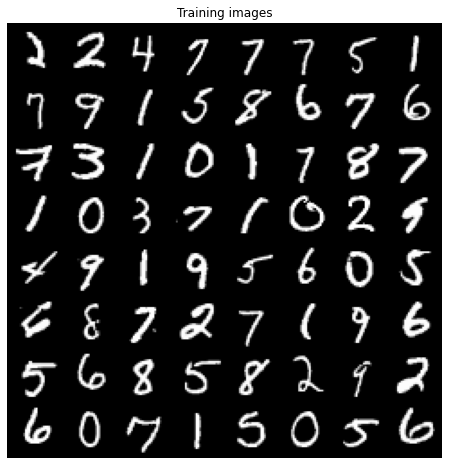

In [7]:
# %load ../code_dataset/plot_visual-check_basic.py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision


for images, labels in train_loader:  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

### Setting up a `DataModule`

- There are three main ways we can prepare the dataset for Lightning. We can
  1. make the dataset part of the model;
  2. set up the data loaders as usual and feed them to the fit method of a Lightning Trainer -- the Trainer is introduced in the following subsection;
  3. create a LightningDataModule.
- Here, we will use approach 3, which is the most organized approach. The `LightningDataModule` consists of several self-explanatory methods, as we can see below:

In [8]:
# %load ../code_lightningmodule/datamodule_mnist_basic.py
from torch.utils.data.dataset import random_split


class DataModule(pl.LightningDataModule):
    def __init__(self, data_path="./"):
        super().__init__()
        self.data_path = data_path

    def prepare_data(self):
        datasets.MNIST(root=self.data_path, download=True)
        return

    def setup(self, stage=None):
        # Note transforms.ToTensor() scales input images
        # to 0-1 range
        train = datasets.MNIST(
            root=self.data_path,
            train=True,
            transform=transforms.ToTensor(),
            download=False,
        )

        self.test = datasets.MNIST(
            root=self.data_path,
            train=False,
            transform=transforms.ToTensor(),
            download=False,
        )

        self.train, self.valid = random_split(train, lengths=[55000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=BATCH_SIZE,
            drop_last=True,
            shuffle=True,
            num_workers=NUM_WORKERS,
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )
        return test_loader


- Note that the `prepare_data` method is usually used for steps that only need to be executed once, for example, downloading the dataset; the `setup` method defines the dataset loading -- if we run our code in a distributed setting, this will be called on each node / GPU. 
- Next, let's initialize the `DataModule`; we use a random seed for reproducibility (so that the data set is shuffled the same way when we re-execute this code):

In [9]:
torch.manual_seed(1) 
data_module = DataModule(data_path='./data')

## Training the model using the PyTorch Lightning Trainer class

- Next, we initialize our model.
- Also, we define a call back to obtain the model with the best validation set performance after training.
- PyTorch Lightning offers [many advanced logging services](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) like Weights & Biases. However, here, we will keep things simple and use the `CSVLogger`:

In [10]:
pytorch_model = PyTorchModel(
    input_size=28*28,
    hidden_units=HIDDEN_UNITS,
    num_classes=10
)

In [11]:
# %load ../code_lightningmodule/logger_csv_acc_basic.py
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


lightning_model = LightningModel(pytorch_model, learning_rate=LEARNING_RATE)

callbacks = [
    ModelCheckpoint(
        save_top_k=1, mode="max", monitor="valid_acc"
    )  # save top 1 model
]
logger = CSVLogger(save_dir="logs/", name="my-model")

- Now it's time to train our model:

In [12]:
# %load ../code_lightningmodule/trainer_nb_basic.py
import time


trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    progress_bar_refresh_rate=50,  # recommended for notebooks
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    deterministic=True,
    log_every_n_steps=10,
)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time) / 60
print(f"Training took {runtime:.2f} min in total.")


/Users/sebastian/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=50)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type         | Params
-------------------------------------------
0 | model     | PyTorchModel | 135 K 
1 | train_acc | Accuracy     | 0     
2 | valid_acc | Accuracy     | 0     
3 | test_acc  | Accuracy     | 0     
-------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.543     Total estimated model

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training took 1.26 min in total.


## Evaluating the model

- After training, let's plot our training ACC and validation ACC using pandas, which, in turn, uses matplotlib for plotting (PS: you may want to check out [more advanced logger](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) later on, which take care of it for us):

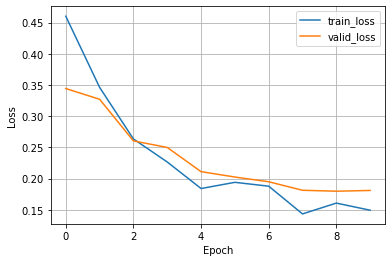

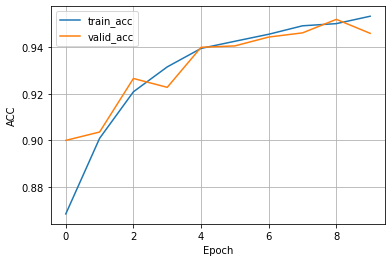

In [13]:
# %load ../code_lightningmodule/logger_csv_plot_basic.py
import pandas as pd
import matplotlib.pyplot as plt


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

- The `trainer` automatically saves the model with the best validation accuracy automatically for us, we which we can load from the checkpoint via the `ckpt_path='best'` argument; below we use the `trainer` instance to evaluate the best model on the test set:

In [14]:
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')

Restoring states from the checkpoint path at logs/my-model/version_1/checkpoints/epoch=8-step=1925.ckpt
Loaded model weights from checkpoint at logs/my-model/version_1/checkpoints/epoch=8-step=1925.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9478999972343445}
--------------------------------------------------------------------------------


[{'test_acc': 0.9478999972343445}]

## Predicting labels of new data

- We can use the `trainer.predict` method either on a new `DataLoader` (`trainer.predict(dataloaders=...)`) or `DataModule` (`trainer.predict(datamodule=...)`) to apply the model to new data.
- Alternatively, we can also manually load the best model from a checkpoint as shown below:

In [15]:
path = trainer.checkpoint_callback.best_model_path
print(path)

logs/my-model/version_1/checkpoints/epoch=8-step=1925.ckpt


In [16]:
lightning_model = LightningModel.load_from_checkpoint(path, model=pytorch_model)
lightning_model.eval();

- For simplicity, we reused our existing `pytorch_model` above. However, we could also reinitialize the `pytorch_model`, and the `.load_from_checkpoint` method would load the corresponding model weights for us from the checkpoint file.
- Now, below is an example applying the model manually. Here, pretend that the `test_dataloader` is a new data loader.

In [17]:
# %load ../code_lightningmodule/datamodule_testloader.py
test_dataloader = data_module.test_dataloader()
acc = torchmetrics.Accuracy()

for batch in test_dataloader:
    features, true_labels = batch

    with torch.no_grad():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    acc(predicted_labels, true_labels)

predicted_labels[:5]


tensor([1, 2, 3, 4, 5])

- As an internal check, if the model was loaded correctly, the test accuracy below should be identical to the test accuracy we saw earlier in the previous section.

In [18]:
test_acc = acc.compute()
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

Test accuracy: 0.9479 (94.79%)


## Inspecting Failure Cases

- In practice, it is often informative to look at failure cases like wrong predictions for particular training instances as it can give us some insights into the model behavior and dataset.
- Inspecting failure cases can sometimes reveal interesting patterns and even highlight dataset and labeling issues.

In [19]:
# In the case of MNIST, the class label mapping
# is relatively trivial
class_dict = {0: 'digit 0',
              1: 'digit 1',
              2: 'digit 2',
              3: 'digit 3',
              4: 'digit 4',
              5: 'digit 5',
              6: 'digit 6',
              7: 'digit 7',
              8: 'digit 8',
              9: 'digit 9'}

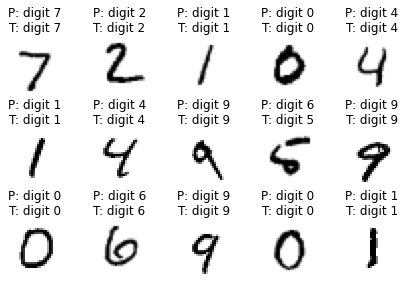

In [20]:
# %load ../code_lightningmodule/plot_failurecases_basic.py
# Append the folder that contains the
# helper_data.py, helper_plotting.py, and helper_evaluate.py
# files so we can import from them

import sys
from helper_plotting import show_examples


show_examples(
    model=lightning_model, data_loader=test_dataloader, class_dict=class_dict
)


- In addition to inspecting failure cases visually, it is also informative to look at which classes the model confuses the most via a confusion matrix:

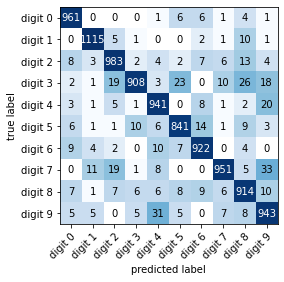

In [21]:
# %load ../code_lightningmodule/plot_confusion-matrix_basic.py
from torchmetrics import ConfusionMatrix
import matplotlib
from helper_plotting import plot_confusion_matrix


cmat = ConfusionMatrix(num_classes=len(class_dict))

for x, y in test_dataloader:

    with torch.no_grad():
        pred = lightning_model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm()  
    # normed colormaps highlight the off-diagonals 
    # for high-accuracy models better
)

plt.show()

In [22]:
%watermark --iversions

sys              : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:24:02) 
[Clang 11.1.0 ]
pytorch_lightning: 1.5.9
torchmetrics     : 0.7.2
pandas           : 1.4.0
matplotlib       : 3.5.1
numpy            : 1.22.1
torch            : 1.10.2
torchvision      : 0.11.3

